In [5]:
!py -3.11 -m venv env311
!.\env311\Scripts\activate

/bin/bash: line 1: py: command not found
/bin/bash: line 1: .env311Scriptsactivate: command not found


In [6]:
!pip3 install torch torchvision torchaudio -- index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

  ERROR: Cannot unpack file /tmp/pip-unpack-mr4srv5l/cu118.html (downloaded from /tmp/pip-req-build-y0x3lit8, content-type: text/html); cannot detect archive format
ERROR: Cannot determine archive format of /tmp/pip-req-build-y0x3lit8
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-oamf9pnc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-oamf9pnc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [7]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2025-10-28 06:11:47--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth.1’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  70.9MB/s    in 3.6s    

2025-10-28 06:11:51 (99.3 MB/s) - ‘sam_vit_b_01ec64.pth.1’ saved [375042383/375042383]



In [8]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2025-10-28 06:11:51--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.51, 3.163.189.14, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  94.9MB/s    in 48s     

2025-10-28 06:12:38 (51.1 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



Loading Model ... 
Loading Image ... 


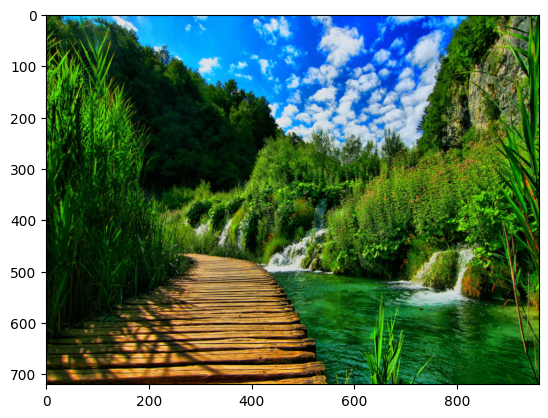

Generating Masks ... 


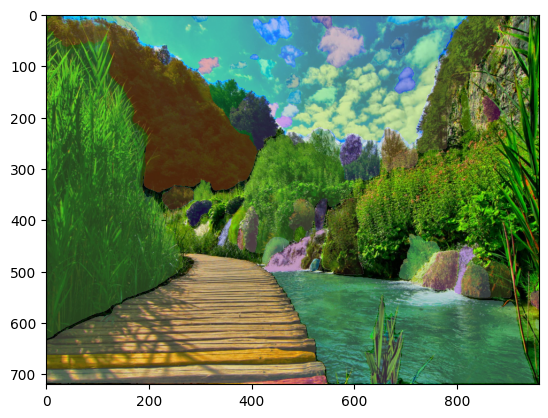

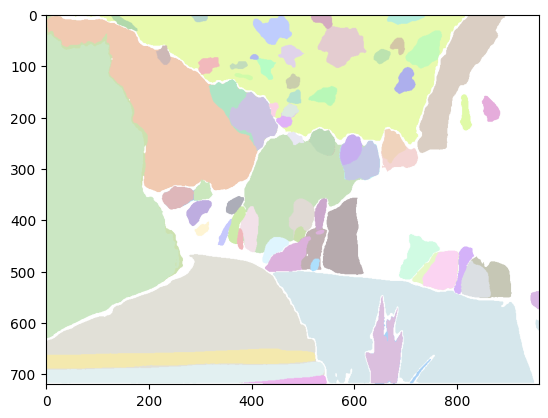

Saving Results ... 


In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

class ModelType(Enum):
    vit_b = 'sam_vit_b_01ec64.pth' # smallest model
    vit_h = 'sam_vit_h_4b8939.pth' # largest model

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    return img

def is_point_inside_bbox(point_x, point_y, bbox):
    bbox_x, bbox_y, bbox_width, bbox_height = bbox
    is_inside_x = bbox_x <= point_x < bbox_x + bbox_width
    is_inside_y = bbox_y <= point_y < bbox_y + bbox_height
    return is_inside_x and is_inside_y

class SegmentAnything():
    def __init__(self, model: ModelType):
        print('Loading Model ... ')
        sam_checkpoint = model.value
        self.model_name = model.name
        self.sam = sam_model_registry[self.model_name](checkpoint=sam_checkpoint)

        # Only small model works for my gpu, large is too big
        if model == ModelType.vit_b:
            print(' Using Cuda ... ')
            device = "cuda"
            self.sam.to(device=device)

    def loadImage(self, imgPath):
        print('Loading Image ... ')
        img = cv2.imread(imgPath)
        self.img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(self.img)
        plt.show()

    def saveResults(self, imgMask, tuned=False):
        print('Saving Results ... ')
        imgMask = (imgMask * 255).astype(np.uint8)
        rgb = imgMask[:, :, :3]
        alpha = imgMask[:, :, 3] / 255.0
        combined = np.zeros_like(self.img)
        for c in range(3):
            combined[:, :, c] = alpha * rgb[:, :, c] + (1 - alpha) * self.img[:, :, c]
        combined = cv2.cvtColor(combined, cv2.COLOR_RGB2BGR)

        if tuned:
            cv2.imwrite('result-mask-' + self.model_name + '-tuned.png', imgMask)
            cv2.imwrite('result-combined-' + self.model_name + '-tuned.png', combined)
        else:
            cv2.imwrite('result-mask-' + self.model_name + '.png', imgMask)
            cv2.imwrite('result-combined-' + self.model_name + '.png', combined)

    def generateMasks(self):
        print('Generating Masks ... ')
        mask_generator = SamAutomaticMaskGenerator(self.sam)
        maskList = mask_generator.generate(self.img)
        plt.figure()
        plt.imshow(self.img)
        imgMask = show_anns(maskList)
        plt.show()

        plt.figure()
        plt.imshow(imgMask)
        plt.show()
        self.saveResults(imgMask)

    def generateTunedMasks(self):
        print('Generating Tuned Masks ... ')
        mask_generator_tuned = SamAutomaticMaskGenerator(
            model=self.sam,
            points_per_side=32,
            pred_iou_thresh=0.86,
            stability_score_thresh=0.92,
            crop_n_layers=1,
            crop_n_points_downscale_factor=2,
            min_mask_region_area=100,
        )
        maskList = mask_generator_tuned.generate(self.img)
        plt.figure()
        plt.imshow(self.img)
        imgMask = show_anns(maskList)
        plt.show()

        plt.figure()
        plt.imshow(imgMask)
        plt.show()
        self.saveResults(imgMask, tuned=True)

    def generateSingleMask(self, coord):
        print('Generating Masks ... ')
        mask_generator = SamAutomaticMaskGenerator(self.sam)
        masks = mask_generator.generate(self.img)

        for mask in masks:
            if is_point_inside_bbox(coord[0], coord[1], mask['bbox']):
                plt.figure()
                plt.imshow(mask['segmentation'])
                plt.plot(coord[0], coord[1], 'ro') # Added 'ro' for better visibility of the point
                plt.show()
                color_true = [255, 255, 255]
                color_false = [0, 0, 0]
                mask_rgb = np.zeros((mask['segmentation'].shape[0], mask['segmentation'].shape[1], 3), dtype=np.uint8)
                mask_rgb[mask['segmentation']] = color_true
                mask_rgb[~mask['segmentation']] = color_false
                print('Saving Results ... ')
                cv2.imwrite('result-mask-single-' + self.model_name + '.png', mask_rgb)
                return # Added return to only process the first matching mask

def testSmallModel():
    sa = SegmentAnything(ModelType.vit_b)
    sa.loadImage('/content/image.png')
    sa.generateMasks()

def testLargeModel():
    sa = SegmentAnything(ModelType.vit_h)
    sa.loadImage('/content/image.png')
    sa.generateMasks()

def testLargeModelTuned():
    sa = SegmentAnything(ModelType.vit_h)
    sa.loadImage('/content/image.png')
    sa.generateTunedMasks()

def testSmallModelSingleMask(coord):
    sa = SegmentAnything(ModelType.vit_b)
    sa.loadImage('/content/image.png')
    sa.generateSingleMask(coord)

if __name__ == '__main__':
    #testSmallModel()
    testLargeModel()
    #testLargeModelTuned()
    #testSmallModelSingleMask([300, 700])

blob:https://colab.research.google.com/98d9ffa9-4fc8-4762-9492-f66636ab7d2a

blob:https://colab.research.google.com/ad61765b-0082-4b19-a1ec-ac027c6015ee

Here are some potential next features and updates for your Segment Anything project:

*   **Interactive Segmentation:** Allow users to click on an image and have the model segment the object at that point. You've started this with `generateSingleMask`, but you could make it interactive using libraries like `ipywidgets`.
*   **Bounding Box Input:** Instead of just a single point, allow users to draw a bounding box around an object they want to segment.
*   **Multiple Object Segmentation:** Extend the single mask generation to handle multiple point or bounding box inputs to segment several objects in one image.
*   **Mask Refinement:** Implement ways to refine the generated masks, perhaps by allowing users to add or remove areas from the mask.
*   **Different Models:** Integrate the ability to easily switch between different Segment Anything model sizes (like the 'vit_l' model if you download its checkpoint) or even other segmentation models.
*   **Output Mask Options:** Provide options to save the masks in different formats (e.g., as a binary mask, an outline, or a transparent overlay).
*   **Batch Processing:** Add functionality to process multiple images at once.
*   **User Interface:** Develop a simple graphical user interface (GUI) using libraries like Gradio or Streamlit to make the project more user-friendly.
*   **Performance Optimization:** Explore ways to optimize the model's performance, especially for larger images or real-time applications.
*   **Integration with other Libraries:** Combine Segment Anything with other computer vision libraries for tasks like object detection, image classification, or instance segmentation.

# Task
Add interactive segmentation, bounding box input, multiple input handling, model selection, and improved mask visualization/saving to the image processing project.